# Sample Mass-Difference Networks in Metabolomics Data Analysis

Notebook to support the study on the application of **Sample M**ass-**Di**fference **N**etworks as a highly specific competing form of pre-processing procedure for high-resolution metabolomics data.

Mass-Difference Networks are focused into making networks from a list of masses. Each _m/z_ will represent a node. Nodes will be connected if the difference in their masses can be associated to a simple chemical reaction (enzymatic or non-enzymatic) that led to a change in the elemental composition of its metabolite.

The set of mass differences used to build said networks are called a set of MDBs - Mass-Difference-based Building block.

This is notebook `paper_sMDiNs_unsupervised.ipynb`


## Organization of the Notebook

- Loading up pre-processed and pre-treated datasets databases with intensity-based pre-treated data and data from sMDiNs analyses.
- **Agglomerative Hierarchical Clustering and K-means Clustering: assessment of performence given a ground-truth of cluster assignments.**


#### Needed Imports

In [1]:
import itertools
from pathlib import Path

import numpy as np
import pandas as pd

import scipy.spatial.distance as dist
import scipy.cluster.hierarchy as hier
import scipy.stats as stats

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
from matplotlib import ticker

import seaborn as sns
import networkx as nx

# Metabolinks package
import metabolinks as mtl
import metabolinks.transformations as transf

# Python files in the repository
import multianalysis as ma
from elips import plot_confidence_ellipse

In [2]:
%matplotlib inline

In [3]:
# json for persistence
import json
from time import perf_counter

## Description of dataset records

`datasets` is the global dict that holds all data sets. It is a **dict of dict's**.

Each data set is **represented as a dict**.

Each record has the following fields (keys):

- `name`: the table/figure name of the data set
- `source`: the biological source for each dataset
- `mode`: the aquisition mode
- `alignment`: the alignment used to generate the data matrix
- `data`: the data matrix
- `target`: the sample labels, possibly already integer encoded
- `MDiN`: Mass-Difference Network - Not present here, only on sMDiNsAnalysis notebook
- `<treatment name>`: transformed data matrix / network. These treatment names can be
    - `original`: an alias to `data`
    - `Ionly`: missing value imputed data by 1/5 of the minimum value in each sample in the dataset, only
    - `P`: Pareto scaled data
    - `NP`: Pareto scaled and normalized
    - `NGP`: normalized, glog transformed and Pareto scaled
    - `Ionly_RF`: missing value imputed data by random forests, only
    - `P_RF`: Pareto scaled data
    - `NP_RF`: Pareto scaled and normalized
    - `NGP_RF`: normalized, glog transformed and Pareto scaled
    - **`IDT`: `NGP_RF` or `NGP` - Intensity-based Data pre-Treatment chosen as comparison** based on which of the two performed better for each dataset and each statistical method
    - `sMDiN`: Sample Mass-Difference Networks - Not present here, only on sMDiNsAnalysis notebook
       
- `<sMDiN analysis name>`: data matrix from nework analysis of MDiNs
    - **`Degree`: degree analysis of each sMDiN**
    - **`Betweenness`: betweenness centrality analysis of each sMDiN**
    - **`Closeness`: closeness centrality of analysis of each sMDiN**
    - **`MDBI`: analysis on the impact of each MDB (Mass-Difference based building-block) on building each sMDiN**
    - **`GCD11`: Graphlet Correlation Distance of 11 different orbits (maximum of 4-node graphlets) between each sMDiN.**

The keys of `datasets` may be shared with dicts holding records resulting from comparison analysis.

Here are the keys (and respective names) of datasets used in this study:

- GD_neg_global2 (GDg2-)
- GD_pos_global2 (GDg2+)
- GD_neg_class2 (GDc2-)
- GD_pos_class2 (GDc2+)
- YD (YD)
- vitis_types (GD types)
- HD (HD)

#### Data Pre-Treatment

For information on the **commonly used intensity based data pre-treatments** and about the **benchmark datasets**, see notebook `paper_sMDiNs_database_prep.ipynb`.

For information on the **building** and the different **network analysis methods** used for the **Sample MDiNs** and information about the Mass-Difference-based Building blocks (**MDBs**), see notebook `paper_sMDiNs_sMDiNsAnalysis.ipynb`.

### Reading datasets database

In [4]:
# Read benchmark datasets
path = Path.cwd() / "store_files" / 'processed_data.json'
storepath = Path.cwd() / "store_files" / 'processed_data.h5'
with pd.HDFStore(storepath) as store:

    with open(path, encoding='utf8') as read_file:
        datasets = json.load(read_file)
    
    for dskey, dataset in datasets.items():
        for key in dataset:
            value = dataset[key]
            if isinstance(value, str) and value.startswith("INSTORE"):
                storekey = value.split("_", 1)[1]
                dataset[key] = store[storekey]
#datasets

In [5]:
datasets['YD']['Ionly']

,307.083818,555.269298,624.087308,493.316816,257.102875,780.109207,347.063081,254.224610,625.086929,663.109142,...,734.677027,648.574264,634.548871,675.482247,739.516465,916.507669,550.163642,914.598352,802.744007,535.097415
BY0_1,391042880.0,111270160.0,130088936.0,1.122515e+08,54234476.0,33863468.0,35209136.0,9935943.0,25313166.0,21631346.0,...,726365.5625,110414.2375,110414.2375,110414.2375,110414.2375,110414.2375,110414.2375,110414.2375,110414.2375,110414.2375
BY0_2,398003680.0,110423984.0,127133608.0,1.139838e+08,53720908.0,32622178.0,35636648.0,17679414.0,24989162.0,24420090.0,...,111136.7625,111136.7625,111136.7625,111136.7625,111136.7625,111136.7625,111136.7625,111136.7625,111136.7625,111136.7625
BY0_3,399481952.0,111225424.0,131208568.0,1.158259e+08,55826148.0,34655496.0,37943456.0,19530026.0,24684334.0,24862190.0,...,666204.7500,110903.5750,110903.5750,110903.5750,110903.5750,110903.5750,558134.1875,110903.5750,110903.5750,110903.5750
GRE3_1,270906400.0,92849040.0,130682664.0,1.104378e+08,46503348.0,33206608.0,32640452.0,5713388.5,25890872.0,28692028.0,...,109408.1500,109408.1500,109408.1500,109408.1500,109408.1500,109408.1500,613780.4375,109408.1500,109408.1500,109408.1500
GRE3_2,271023520.0,94888320.0,130844488.0,1.144803e+08,44828256.0,34597444.0,31696134.0,10139615.0,25548978.0,26964150.0,...,109397.2500,109397.2500,109397.2500,109397.2500,109397.2500,109397.2500,109397.2500,109397.2500,579154.7500,109397.2500
GRE3_3,274854272.0,94514272.0,130896568.0,1.233897e+08,46361588.0,33131336.0,31668180.0,16434200.0,25518902.0,26654308.0,...,110729.9750,110729.9750,110729.9750,110729.9750,110729.9750,110729.9750,110729.9750,110729.9750,110729.9750,110729.9750
ENO1_1,255276736.0,150620544.0,136612464.0,3.220034e+07,72465536.0,35298204.0,31236114.0,10759292.0,25798230.0,22221992.0,...,106505.5875,106505.5875,720792.6250,106505.5875,106505.5875,106505.5875,106505.5875,106505.5875,106505.5875,538023.5625
ENO1_2,251610656.0,148516304.0,134972800.0,3.422184e+07,70376640.0,35198252.0,30789652.0,25896608.0,26849502.0,23433602.0,...,107276.0250,107276.0250,107276.0250,107276.0250,107276.0250,626384.6250,107276.0250,609298.9375,107276.0250,107276.0250
ENO1_3,251024624.0,150645840.0,135922432.0,3.370513e+07,68912816.0,34380756.0,30916958.0,29723808.0,26606410.0,23500090.0,...,107625.1125,655682.1875,624387.0000,107625.1125,561889.8750,107625.1125,107625.1125,107625.1125,107625.1125,107625.1125
dGLO1_1,283822048.0,202869216.0,130259064.0,4.167029e+07,58269456.0,32095004.0,29669478.0,26538900.0,26013280.0,21245436.0,...,108130.3500,108130.3500,108130.3500,108130.3500,108130.3500,108130.3500,108130.3500,548121.4375,108130.3500,108130.3500


In [6]:
# Selecting a placeholder for the Intensity-based Data pre-Treatment (IDT)
# Chosen for each dataset and each method based on which between NGP and NGP_RF generated the best results
for name, ds in datasets.items():
    ds['IDT'] = ds['NGP_RF'] 

Extra Possibly Useful Data

In [7]:
# Atomic masses - https://ciaaw.org/atomic-masses.htm
#Isotopic abundances-https://ciaaw.org/isotopic-abundances.htm/https://www.degruyter.com/view/journals/pac/88/3/article-p293.xml
# Isotopic abundances from Pure Appl. Chem. 2016; 88(3): 293–306,
# Isotopic compositions of the elements 2013 (IUPAC Technical Report), doi: 10.1515/pac-2015-0503

chemdict = {'H':(1.0078250322, 0.999844),
            'C':(12.000000000, 0.988922),
            'N':(14.003074004, 0.996337),
            'O':(15.994914619, 0.9976206),
            'Na':(22.98976928, 1.0),
            'P':(30.973761998, 1.0),
            'S':(31.972071174, 0.9504074),
            'Cl':(34.9688527, 0.757647),
            'F':(18.998403163, 1.0),
            'C13':(13.003354835, 0.011078) # Carbon 13 isotope
           } 

# electron mass from NIST http://physics.nist.gov/cgi-bin/cuu/Value?meu|search_for=electron+mass
electron_mass = 0.000548579909065

In [8]:
# Chemical Formula transformations (MDBs chosen)
MDBs = ['H2','CH2','CO2','O','CHOH','NCH','O(N-H-)','S','CONH','PO3H','NH3(O-)','SO3','CO', 'C2H2O', 'H2O']

### Colors for plots to ensure consistency

#### 11 variety grapevine data sets

In [9]:
# customize label colors for 11 grapevine varieties

colours = sns.color_palette('Blues', 3)
colours.extend(sns.color_palette('Greens', 3))
#colours = sns.cubehelix_palette(n_colors=6, start=2, rot=0, dark=0.2, light=.9, reverse=True)
colours.extend(sns.color_palette('flare', 5))

ordered_vitis_labels = ('CAN','RIP','ROT','RU','LAB','SYL','REG','CS','PN','RL','TRI')

vitis_label_colors = {lbl: c for lbl, c in zip(ordered_vitis_labels, colours)}

tab20bcols = sns.color_palette('tab20b', 20)
tab20ccols = sns.color_palette('tab20c', 20)
tab20cols = sns.color_palette('tab20', 20)
tab10cols = sns.color_palette('tab10', 10)
dark2cols = sns.color_palette('Dark2', 8)

vitis_label_colors['RU'] = tab20bcols[8]
vitis_label_colors['CAN'] = tab20ccols[5]
vitis_label_colors['REG'] = tab10cols[3]

for name in datasets:
    if name.startswith('GD'):
        datasets[name]['label_colors'] = vitis_label_colors
        datasets[name]['sample_colors'] = [vitis_label_colors[lbl] for lbl in datasets[name]['target']]

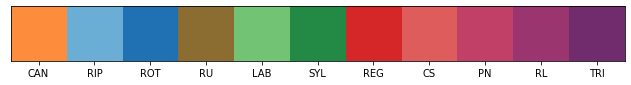

In [10]:
sns.palplot(vitis_label_colors.values())
new_ticks = plt.xticks(range(len(ordered_vitis_labels)), ordered_vitis_labels)

#### 5 yeast strains

In [11]:
# customize label colors for 5 yeast strains

colours = sns.color_palette('Set1', 5)
yeast_classes = datasets['YD']['classes']
yeast_label_colors = {lbl: c for lbl, c in zip(yeast_classes, colours)}
datasets['YD']['label_colors'] = yeast_label_colors
datasets['YD']['sample_colors'] = [yeast_label_colors[lbl] for lbl in datasets['YD']['target']]

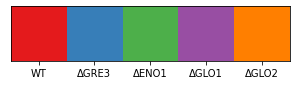

In [12]:
sns.palplot(yeast_label_colors.values())
new_ticks = plt.xticks(range(len(yeast_classes)), yeast_classes)

#### 2 classes of Vitis types (wild and _vinifera_)

In [13]:
# customize label colors for 2 types of Vitis varieties

colours = [vitis_label_colors['SYL'], vitis_label_colors['TRI']]
vitis_type_classes = datasets['vitis_types']['classes']
vitis_types_label_colors = {lbl: c for lbl, c in zip(vitis_type_classes, colours)}
datasets['vitis_types']['label_colors'] = vitis_types_label_colors
datasets['vitis_types']['sample_colors'] = [vitis_types_label_colors[lbl] for lbl in datasets['vitis_types']['target']]

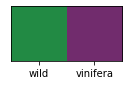

In [14]:
sns.palplot(datasets['vitis_types']['label_colors'].values())
new_ticks = plt.xticks(range(len(datasets['vitis_types']['classes'])), datasets['vitis_types']['classes'])

#### 2 HD classes

In [15]:
# customize label colors for 2 HD classes

colours = sns.color_palette('Set1', 2)
hd_label_colors = {lbl: c for lbl, c in zip(datasets['HD']['classes'], colours)}
datasets['HD']['label_colors'] = hd_label_colors
datasets['HD']['sample_colors'] = [hd_label_colors[lbl] for lbl in datasets['HD']['target']]

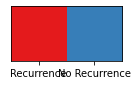

In [16]:
sns.palplot(hd_label_colors.values())
new_ticks = plt.xticks(range(len(datasets['HD']['classes'])), datasets['HD']['classes'])

Samples and respective target labels of each dataset

In [17]:
def styled_sample_labels(sample_names, sample_labels, label_colors):

    meta_table = pd.DataFrame({'label': sample_labels,
                               'sample': sample_names}).set_index('sample').T

    def apply_label_color(val):
        red, green, blue = label_colors[val]
        red, green, blue = int(red*255), int(green*255), int(blue*255)   
        hexcode = '#%02x%02x%02x' % (red, green, blue)
        css = f'background-color: {hexcode}'
        return css
    
    return meta_table.style.applymap(apply_label_color)

In [18]:
parsed = mtl.parse_data(datasets['GD_pos_class2']['data'], labels_loc='label')
y = datasets['GD_pos_class2']['target']
label_colors = datasets['GD_pos_class2']['label_colors']
s = styled_sample_labels(parsed.sample_names, y, label_colors)
s

sample,14,15,16,29,30,31,8,9,10,23,24,25,38,39,40,17,18,19,26,27,28,20,21,22,35,36,37,11,12,13,32,33,34
label,CAN,CAN,CAN,CS,CS,CS,LAB,LAB,LAB,PN,PN,PN,REG,REG,REG,RIP,RIP,RIP,RL,RL,RL,ROT,ROT,ROT,RU,RU,RU,SYL,SYL,SYL,TRI,TRI,TRI


In [19]:
parsed = mtl.parse_data(datasets['YD']['data'])
y = datasets['YD']['target']
label_colors = datasets['YD']['label_colors']
s = styled_sample_labels(parsed.sample_names, y, label_colors)
s

sample,BY0_1,BY0_2,BY0_3,GRE3_1,GRE3_2,GRE3_3,ENO1_1,ENO1_2,ENO1_3,dGLO1_1,dGLO1_2,dGLO1_3,GLO2_1,GLO2_2,GLO2_3
label,WT,WT,WT,ΔGRE3,ΔGRE3,ΔGRE3,ΔENO1,ΔENO1,ΔENO1,ΔGLO1,ΔGLO1,ΔGLO1,ΔGLO2,ΔGLO2,ΔGLO2


In [20]:
parsed = mtl.parse_data(datasets['vitis_types']['data'], labels_loc='label')
y = datasets['vitis_types']['target']
label_colors = datasets['vitis_types']['label_colors']
s = styled_sample_labels(parsed.sample_names, y, label_colors)
s

sample,14,15,16,29,30,31,8,9,10,23,24,25,38,39,40,17,18,19,26,27,28,20,21,22,35,36,37,11,12,13,32,33,34
label,wild,wild,wild,vinifera,vinifera,vinifera,wild,wild,wild,vinifera,vinifera,vinifera,vinifera,vinifera,vinifera,wild,wild,wild,vinifera,vinifera,vinifera,wild,wild,wild,wild,wild,wild,wild,wild,wild,vinifera,vinifera,vinifera


In [21]:
parsed = mtl.parse_data(datasets['HD']['data'])
y = datasets['HD']['target']
label_colors = datasets['HD']['label_colors']
s = styled_sample_labels(parsed.sample_names, y, label_colors)
s

sample,S10_1,S10_2,S10_3,S15_1,S15_2,S15_3,S25_1,S25_2,S25_3,S34_1,S34_2,S34_3,S35_1,S35_2,S35_3,S37_1,S37_2,S37_3,S39_1,S39_2,S39_3,S45_1,S45_2,S45_3,S48_1,S48_2,S48_3,S49_1,S49_2,S49_3,S50_1,S50_2,S50_3,S51_1,S51_2,S51_3,S52_1,S52_2,S52_3,S53_1,S53_2,S53_3,S54_1,S54_2,S54_3,S57_1,S57_2,S57_3,S58_1,S58_2,S58_3,S59_1,S59_2,S59_3,S60_1,S60_2,S60_3,S61_1,S61_2,S61_3,S62_1,S62_2,S62_3,S63_1,S63_2,S63_3,S64_1,S64_2,S64_3,S65_1,S65_2,S65_3,S68_1,S68_2,S68_3,S69A_1,S69A_2,S69A_3,S69B_1,S69B_2,S69B_3,S71_1,S71_2,S71_3,S73_1,S73_2,S73_3,S74_1,S74_2,S74_3,S75_1,S75_2,S75_3,S76_1,S76_2,S76_3,S78_1,S78_2,S78_3,S79_1,S79_2,S79_3,S80_1,S80_2,S80_3,S81_1,S81_2,S81_3,S82_1,S82_2,S82_3,S83_1,S83_2,S83_3,S1_1,S1_2,S1_3,S2_1,S2_2,S2_3,S3_1,S3_2,S3_3,S4_1,S4_2,S4_3,S5_1,S5_2,S5_3,S6_1,S6_2,S6_3,S8_1,S8_2,S8_3,S9_1,S9_2,S9_3,S11_1,S11_2,S11_3,S12_1,S12_2,S12_3,S13A_1,S13A_2,S13A_3,S13B_1,S13B_2,S13B_3,S14_1,S14_2,S14_3,S16_1,S16_2,S16_3,S17_1,S17_2,S17_3,S18_1,S18_2,S18_3,S19_1,S19_2,S19_3,S20A_1,S20A_2,S20A_3,S20B_1,S20B_2,S20B_3,S21_1,S21_2,S21_3,S22_1,S22_2,S22_3,S23_1,S23_2,S23_3,S24_1,S24_2,S24_3,S26_1,S26_2,S26_3,S27_1,S27_2,S27_3,S28_1,S28_2,S28_3,S29_1,S29_2,S29_3,S30_1,S30_2,S30_3,S31_1,S31_2,S31_3,S32_1,S32_2,S32_3,S33_1,S33_2,S33_3,S36_1,S36_2,S36_3,S38_1,S38_2,S38_3,S41_1,S41_2,S41_3,S42_1,S42_2,S42_3,S43_1,S43_2,S43_3,S44_1,S44_2,S44_3,S46_1,S46_2,S46_3,S47_1,S47_2,S47_3,S66A_1,S66A_2,S66A_3,S66B_1,S66B_2,S66B_3,S67_1,S67_2,S67_3,S70_1,S70_2,S70_3,S72_1,S72_2,S72_3,S77_1,S77_2,S77_3
label,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recu

#### Colors for the pre-treatments / sMDiN analysis metrics for the plots

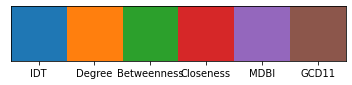

In [22]:
# customize colors for the intensity-based pre-treatment and analysis metrics of sample MDiNs
treatments = ('IDT', 'Degree', 'Betweenness', 'Closeness', 'MDBI', 'GCD11')

treat_colors = tab10cols[:6]
#treat_colors.extend(tab10cols[6:8])
#treat_colors.extend(tab10cols[4:6])
treatment_colors = {lbl: c for lbl, c in zip(treatments, treat_colors)}

sns.palplot(treatment_colors.values())
new_ticks = plt.xticks(range(len(treatment_colors)), treatment_colors)

### PCA scores plots for the 7 datasets

Representation of the samples when projected in the 2 Principal Components obtained from PCA.

Preliminary assessment of the extent of class’s proximity, and consequent degree of difficulty for clustering and classification methods. Greater proximity/overlap would mean a more difficult task for the methods since it would mean the classes are similar to each other or less well defined.

Ellipses shown are 95% confidence ellipses for each class.

In [23]:
def plot_PCA(principaldf, label_colors, components=(1,2), title="PCA", ax=None):
    "Plot the projection of samples in the 2 main components of a PCA model."
    
    if ax is None:
        ax = plt.gca()
    
    loc_c1, loc_c2 = [c - 1 for c in components]
    col_c1_name, col_c2_name = principaldf.columns[[loc_c1, loc_c2]]
    
    #ax.axis('equal')
    ax.set_xlabel(f'{col_c1_name}')
    ax.set_ylabel(f'{col_c2_name}')

    unique_labels = principaldf['Label'].unique()

    for lbl in unique_labels:
        subset = principaldf[principaldf['Label']==lbl]
        ax.scatter(subset[col_c1_name],
                   subset[col_c2_name],
                   s=50, color=label_colors[lbl], label=lbl)

    #ax.legend(framealpha=1)
    ax.set_title(title, fontsize=15)

def plot_ellipses_PCA(principaldf, label_colors, components=(1,2),ax=None, q=None, nstd=2):
    "Plot confidence ellipses of a class' samples based on their projection in the 2 main components of a PCA model."
    
    if ax is None:
        ax = plt.gca()
    
    loc_c1, loc_c2 = [c - 1 for c in components]
    points = principaldf.iloc[:, [loc_c1, loc_c2]]
    
    #ax.axis('equal')

    unique_labels = principaldf['Label'].unique()

    for lbl in unique_labels:
        subset_points = points[principaldf['Label']==lbl]
        plot_confidence_ellipse(subset_points, q, nstd, ax=ax, ec=label_colors[lbl], fc='none')


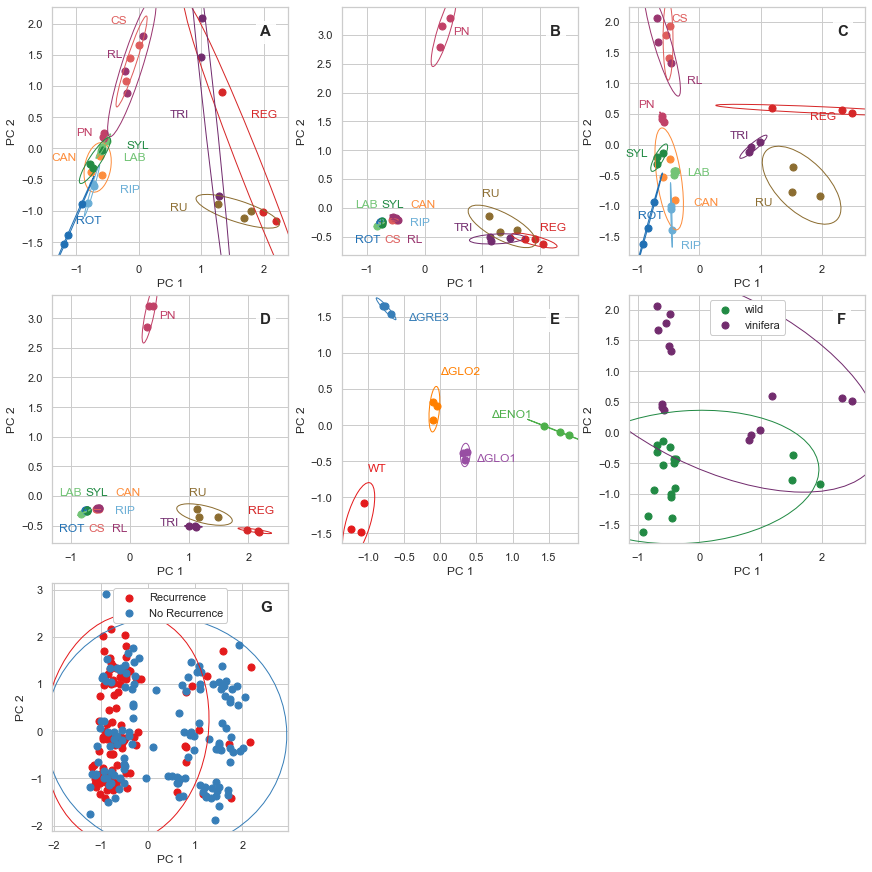

In [24]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1):
        f, axs = plt.subplots(3,3, figsize=(12,12), constrained_layout=True)

        for (dskey, ds), ax in zip(datasets.items(), axs.ravel()):
            df = datasets[dskey]['Ionly']
            tf = transf.FeatureScaler(method='standard')
            df = tf.fit_transform(df)
            #print(df)
            ax.axis('equal')
            principaldf = ma.compute_df_with_PCs(df, n_components=5, whiten=True, labels=datasets[dskey]['target'], return_var_ratios=False)

            lcolors = datasets[dskey]['label_colors']
            #plot_PCA(principaldf, lcolors, components=(1,2), title=datasets[dskey]['name'], ax=ax)
            plot_PCA(principaldf, lcolors, components=(1,2), title='', ax=ax)
            plot_ellipses_PCA(principaldf, lcolors, components=(1,2),ax=ax, q=0.95)

        axs[2][1].remove()
        axs[2][2].remove()
        axs[1][2].legend(loc='upper center', ncol=1, framealpha=1)
        axs[2][0].legend(loc='upper center', ncol=1, framealpha=1)
        
        locs_YD = {'WT':(-1,-0.65),
                   'ΔGRE3':(-0.45, 1.45),
                   'ΔENO1':(0.7, 0.1),
                   'ΔGLO1':(0.5, -0.5),
                   'ΔGLO2':(0,0.7) }
        
        for lbl in datasets['YD']['classes']:
            axs[1][1].text(*locs_YD[lbl], lbl, c=datasets['YD']['label_colors'][lbl])

        locs_GD = {'CAN':(-1.4,-0.2),
                       'CS':(-0.45, 2),
                       'LAB':(-0.25, -0.2),
                       'PN':(-1, 0.2),
                       'REG':(1.8,0.5),
                       'RIP':(-0.3,-0.7),
                       'RL':(-0.5, 1.45),
                       'ROT':(-1, -1.2),
                       'RU':(0.5, -1),
                       'SYL':(-0.2,0),
                       'TRI':(0.5,0.5),}
        
        for lbl in datasets['GD_neg_global2']['classes']:
            axs[0][0].text(*locs_GD[lbl], lbl, c=datasets['GD_neg_global2']['label_colors'][lbl])

        locs_GD = {'CAN':(-0.1,-1),
                       'CS':(-0.45, 2),
                       'LAB':(-0.2, -0.5),
                       'PN':(-1, 0.6),
                       'REG':(1.8,0.4),
                       'RIP':(-0.3,-1.7),
                       'RL':(-0.2, 1),
                       'ROT':(-1, -1.2),
                       'RU':(0.9, -1),
                       'SYL':(-1.2,-0.2),
                       'TRI':(0.5,0.1),}
        
        for lbl in datasets['GD_neg_global2']['classes']:
            axs[0][2].text(*locs_GD[lbl], lbl, c=datasets['GD_neg_global2']['label_colors'][lbl])

        locs_GD = {'CAN':(-0.25,0),
                       'CS':(-0.7, -0.6),
                       'LAB':(-1.2, 0),
                       'PN':(0.5, 3),
                       'REG':(2,-0.3),
                       'RIP':(-0.25,-0.3),
                       'RL':(-0.3, -0.6),
                       'ROT':(-1.2,-0.6),
                       'RU':(1, 0),
                       'SYL':(-0.75,0),
                       'TRI':(0.5,-0.5),}
        
        for lbl in datasets['GD_neg_global2']['classes']:
            axs[1][0].text(*locs_GD[lbl], lbl, c=datasets['GD_neg_global2']['label_colors'][lbl])
        
        locs_GD = {'CAN':(-0.25,0),
                       'CS':(-0.7, -0.6),
                       'LAB':(-1.2, 0),
                       'PN':(0.5, 3),
                       'REG':(2,-0.4),
                       'RIP':(-0.25,-0.3),
                       'RL':(-0.3, -0.6),
                       'ROT':(-1.2,-0.6),
                       'RU':(1, 0.2),
                       'SYL':(-0.75,0),
                       'TRI':(0.5,-0.4),}
        
        for lbl in datasets['GD_neg_global2']['classes']:
            axs[0][1].text(*locs_GD[lbl], lbl, c=datasets['GD_neg_global2']['label_colors'][lbl])
        
        for letter, ax in zip('ABCDEFGHIJ', axs.ravel()[0:7]):
            ax.text(0.88, 0.9, letter, ha='left', va='center', fontsize=15, weight='bold',
                    transform=ax.transAxes,
                    bbox=dict(facecolor='white', alpha=0.9))
        
        plt.show()
        f.savefig('images/PCAs.pdf', dpi=600)
        f.savefig('images/PCAs.png', dpi=600)


## Clustering methods

### Agglomerative Hierarchical Cluster Analysis 

HCA analysis of each differently-treated datasets, results from sample MDiN analysis and corresponding dendrograms.

**Euclidian distance** and **UPGMA linkage** used to build the dendrograms.

Note: `Vitis_types` data set was used only for supervised analysis and is thus not included here since unsupervised analysis does not depend on target labels (even if some of our metrics to evaluate them depend). For example, `Vitis_types` dendrograms would be equal to `GD_neg_class2` since the only difference between these data sets is the target labels.

Note: For the paper, `HD` data set, like for `vitis_types` was used only for supervised analysis and is thus not included here. This is due to the characteristics (very high sample number and number of samples per class) that are not particularly well suited to the discrimination analysis metrics used to analyse the different clusterings. Thus, the results of the `HD` are not shown in the bar plots.

In [25]:
def perform_HCA(df, metric='euclidean', method='average'):
    "Performs Hierarchical Clustering Analysis of a data set with chosen linkage method and distance metric."
    
    distances = dist.pdist(df, metric=metric)
    
    # method is one of
    # ward, average, centroid, single, complete, weighted, median
    Z = hier.linkage(distances, method=method)

    # Cophenetic Correlation Coefficient
    # (see how the clustering - from hier.linkage - preserves the original distances)
    coph = hier.cophenet(Z, distances)
    # Baker's gamma
    mr = ma.mergerank(Z)
    bg = mr[mr!=0]

    return {'Z': Z, 'distances': distances, 'coph': coph, 'merge_rank': mr, "Baker's Gamma": bg}

#### Computation of linkages, distances and cophenetics

Traditional intensity-based pre-treatments

- IDT - **I**ntensity-based **D**ata pre-**T**reatment

Analysis metrics of the Sample MDiNs

- Degree
- Betweenness - Betweenness centrality
- Closeness - Closeness centrality
- MDBI - Mass-Difference based Building block Impact
- GCD11 - Graphlet Correlation Distance using 11 non-redundant graphlet orbits (maximum of 4-node graphlets)


Dictionaries to contain results

In [26]:
HCA_all = {}

Perform the clusterings

In [27]:
for name, ds in datasets.items():
    HCA_all[name] = {}
    #for treat in 'IDT', 'Degree', 'Betweenness', 'Closeness', 'MDBI', 'GCD11':
    for treat in 'NGP', 'NGP_RF', 'Degree', 'Betweenness', 'Closeness', 'MDBI', 'GCD11':
        print(f'Performing HCA to {name} data set with treatment {treat}', end=' ...')
        metric = 'euclidean'
        HCA_all[name][treat] = perform_HCA(datasets[name][treat], metric=metric, method='average')
        print('done!')

Performing HCA to GD_neg_global2 data set with treatment NGP ...done!
Performing HCA to GD_neg_global2 data set with treatment NGP_RF ...done!
Performing HCA to GD_neg_global2 data set with treatment Degree ...done!
Performing HCA to GD_neg_global2 data set with treatment Betweenness ...done!
Performing HCA to GD_neg_global2 data set with treatment Closeness ...done!
Performing HCA to GD_neg_global2 data set with treatment MDBI ...done!
Performing HCA to GD_neg_global2 data set with treatment GCD11 ...done!
Performing HCA to GD_pos_global2 data set with treatment NGP ...done!
Performing HCA to GD_pos_global2 data set with treatment NGP_RF ...done!
Performing HCA to GD_pos_global2 data set with treatment Degree ...done!
Performing HCA to GD_pos_global2 data set with treatment Betweenness ...done!
Performing HCA to GD_pos_global2 data set with treatment Closeness ...done!
Performing HCA to GD_pos_global2 data set with treatment MDBI ...done!
Performing HCA to GD_pos_global2 data set with

In [28]:
# alternative dendogram plots - Newer
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def color_list_to_matrix_and_cmap(colors, ind, axis=0):
        if any(issubclass(type(x), list) for x in colors):
            all_colors = set(itertools.chain(*colors))
            n = len(colors)
            m = len(colors[0])
        else:
            all_colors = set(colors)
            n = 1
            m = len(colors)
            colors = [colors]
        color_to_value = dict((col, i) for i, col in enumerate(all_colors))

        matrix = np.array([color_to_value[c]
                           for color in colors for c in color])

        matrix = matrix.reshape((n, m))
        matrix = matrix[:, ind]
        if axis == 0:
            # row-side:
            matrix = matrix.T

        cmap = mpl.colors.ListedColormap(all_colors)
        return matrix, cmap

def plot_dendogram(Z, leaf_names, label_colors, title='', ax=None, no_labels=False, labelsize=12, **kwargs):
    if ax is None:
        ax = plt.gca()
    hier.dendrogram(Z, labels=leaf_names, leaf_font_size=10, above_threshold_color='0.2', orientation='left',
                    ax=ax, **kwargs)
    #Coloring labels
    #ax.set_ylabel('Distance (AU)')
    ax.set_xlabel('Distance (AU)')
    ax.set_title(title, fontsize = 15)
    
    #ax.tick_params(axis='x', which='major', pad=12)
    ax.tick_params(axis='y', which='major', labelsize=labelsize, pad=12)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    #xlbls = ax.get_xmajorticklabels()
    xlbls = ax.get_ymajorticklabels()
    rectimage = []
    for lbl in xlbls:
        col = label_colors[lbl.get_text()]
        lbl.set_color(col)
        #lbl.set_fontweight('bold')
        if no_labels:
            lbl.set_color('w')
        rectimage.append(col)
    
    cols, cmap = color_list_to_matrix_and_cmap(rectimage, range(len(rectimage)), axis=0)

    axins = inset_axes(ax, width="5%", height="100%",
                   bbox_to_anchor=(1, 0, 1, 1),
                   bbox_transform=ax.transAxes, loc=3, borderpad=0)

    axins.pcolor(cols, cmap=cmap, edgecolors='w', linewidths=1)
    axins.axis('off')

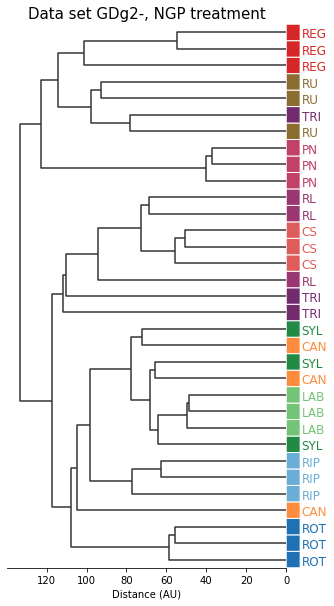

In [29]:
f, ax = plt.subplots(figsize=(5, 10))
name = 'GD_neg_global2'
title = f"Data set {datasets[name]['name']}, NGP treatment"
plot_dendogram(HCA_all[name]['NGP']['Z'], 
               datasets[name]['target'], ax=ax,
               label_colors=datasets[name]['label_colors'], title=title,
               color_threshold=0)

#### Dendrograms of the 4 differently-treated data sets for each of the 6 benchmark data sets

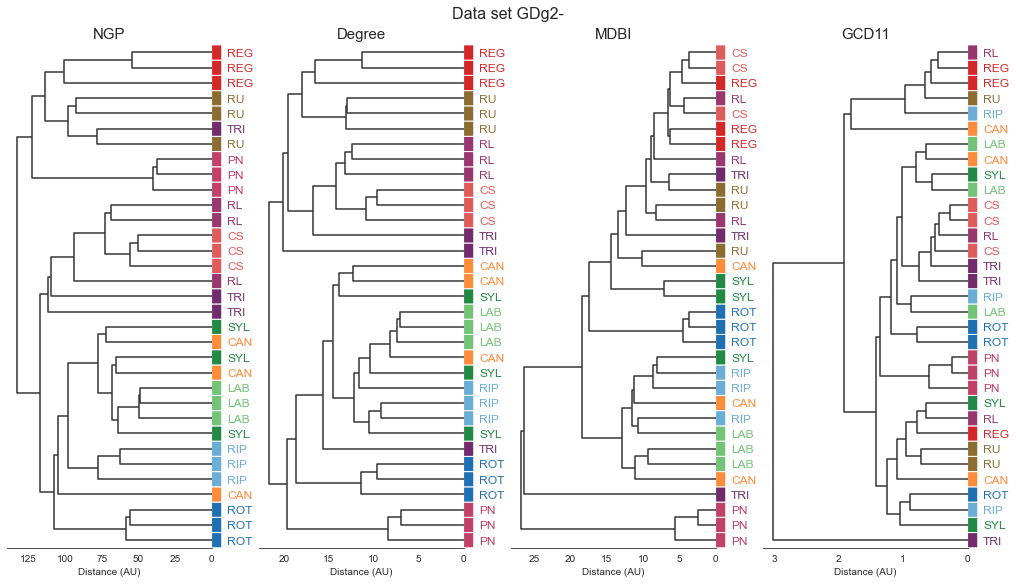

In [30]:
with sns.axes_style("white"):
    f, axs = plt.subplots(1, 4, figsize=(14, 8), constrained_layout=True)
    
    name = 'GD_neg_global2'
    
    for treatment, ax in zip(('NGP', 'Degree', 'MDBI', 'GCD11'), axs.ravel()):
        plot_dendogram(HCA_all[name][treatment]['Z'], 
                       datasets[name]['target'], ax=ax,
                       label_colors=datasets[name]['label_colors'],
                       title=treatment, color_threshold=0)

    st = f.suptitle(f"Data set {datasets[name]['name']}", fontsize=16)
    plt.show()

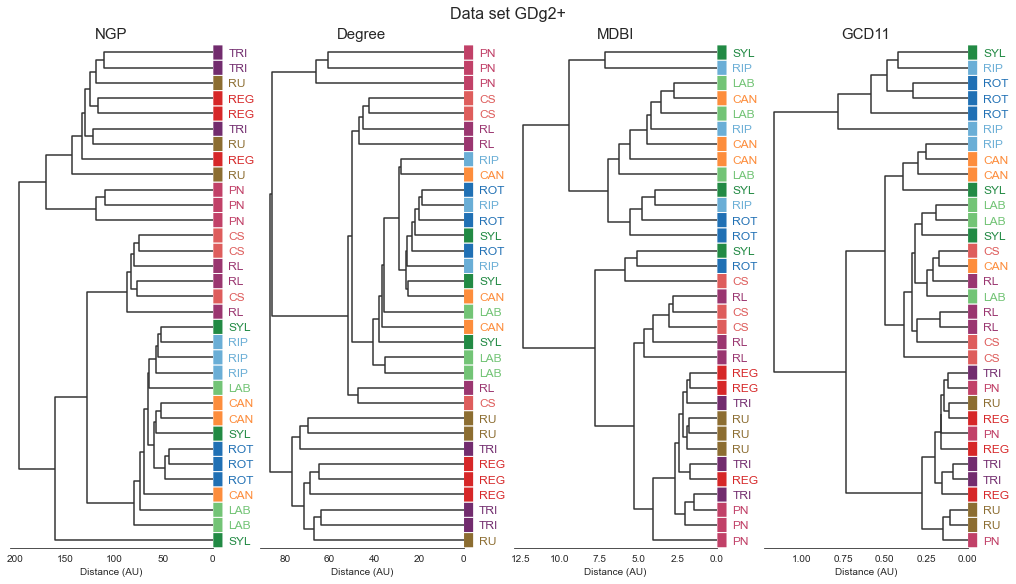

In [31]:
with sns.axes_style("white"):
    f, axs = plt.subplots(1, 4, figsize=(14, 8), constrained_layout=True)
    
    name = 'GD_pos_global2'
      
    for treatment, ax in zip(('NGP', 'Degree', 'MDBI', 'GCD11'), axs.ravel()):
        plot_dendogram(HCA_all[name][treatment]['Z'], 
                       datasets[name]['target'], ax=ax,
                       label_colors=datasets[name]['label_colors'],
                       title=treatment, color_threshold=0)

    st = f.suptitle(f"Data set {datasets[name]['name']}", fontsize=16)
    plt.show()

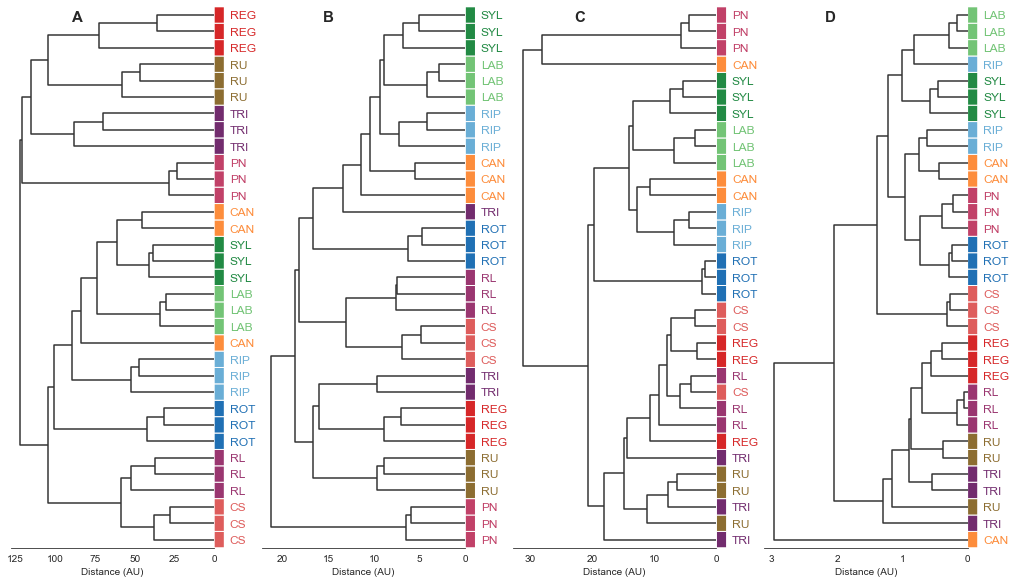

In [32]:
with sns.axes_style("white"):
    f, axs = plt.subplots(1, 4, figsize=(14, 8), constrained_layout=True)
    
    name = 'GD_neg_class2'
      
    for treatment, ax in zip(('NGP', 'Degree', 'MDBI', 'GCD11'), axs.ravel()):
        plot_dendogram(HCA_all[name][treatment]['Z'], 
                       datasets[name]['target'], ax=ax,
                       label_colors=datasets[name]['label_colors'],
                       title='', color_threshold=0)

    #st = f.suptitle(f"Data set {datasets[name]['name']}", fontsize=16)
    for letter, ax in zip('ABCDEFGHIJ', axs.ravel()):
        ax.text(0.3, 0.98, letter, ha='left', va='center', fontsize=15, weight='bold',
                transform=ax.transAxes,
                bbox=dict(facecolor='white', alpha=0.9))

    plt.show()
    f.savefig('images/dendrosGDc2neg.pdf', dpi=600)
    f.savefig('images/dendrosGDc2neg.png', dpi=600)

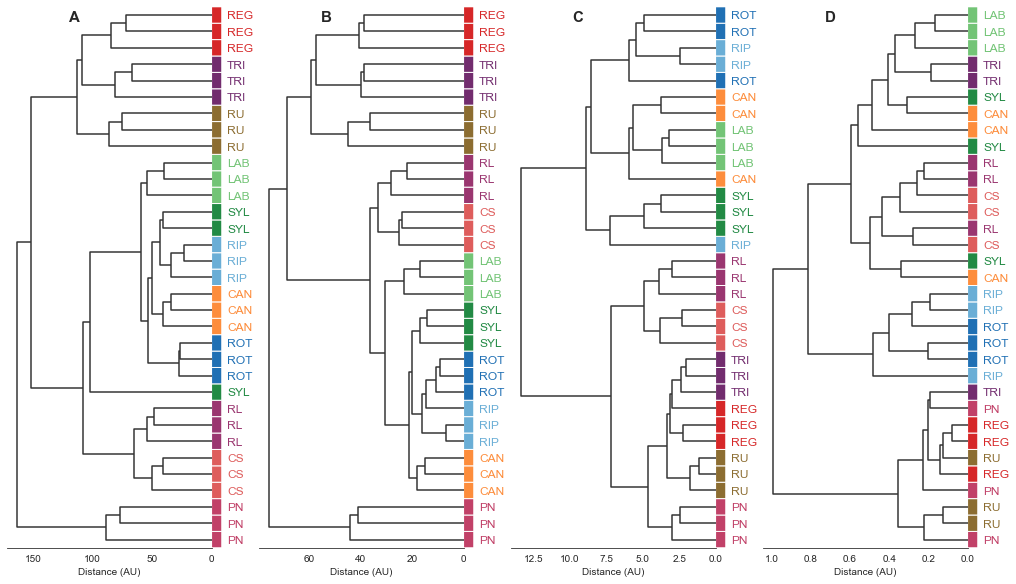

In [33]:
with sns.axes_style("white"):
    f, axs = plt.subplots(1, 4, figsize=(14, 8), constrained_layout=True)
    
    name = 'GD_pos_class2'
      
    for treatment, ax in zip(('NGP', 'Degree', 'MDBI', 'GCD11'), axs.ravel()):
        plot_dendogram(HCA_all[name][treatment]['Z'], 
                       datasets[name]['target'], ax=ax,
                       label_colors=datasets[name]['label_colors'],
                       title='', color_threshold=0)

    #st = f.suptitle(f"Data set {datasets[name]['name']}", fontsize=16)
    for letter, ax in zip('ABCDEFGHIJ', axs.ravel()):
        ax.text(0.3, 0.98, letter, ha='left', va='center', fontsize=15, weight='bold',
                transform=ax.transAxes,
                bbox=dict(facecolor='white', alpha=0.9))

    plt.show()
    #f.savefig('images/dendrosGDpos21.pdf', dpi=200)
    #f.savefig('images/dendrosGDpos21.png', dpi=600)

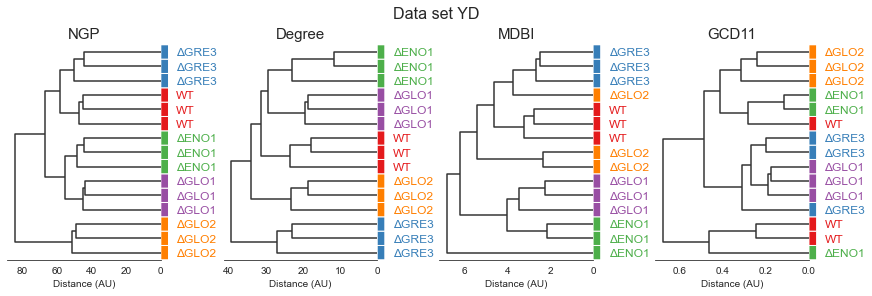

In [34]:
with sns.axes_style("white"):
    f, axs = plt.subplots(1, 4, figsize=(12, 4), constrained_layout=True)
    
    name = 'YD'
      
    for treatment, ax in zip(('NGP', 'Degree', 'MDBI', 'GCD11'), axs.ravel()):
        plot_dendogram(HCA_all[name][treatment]['Z'], 
                       datasets[name]['target'], ax=ax,
                       label_colors=datasets[name]['label_colors'],
                       title=treatment, color_threshold=0)

    st = f.suptitle('Data set YD', fontsize=16)
    plt.show()

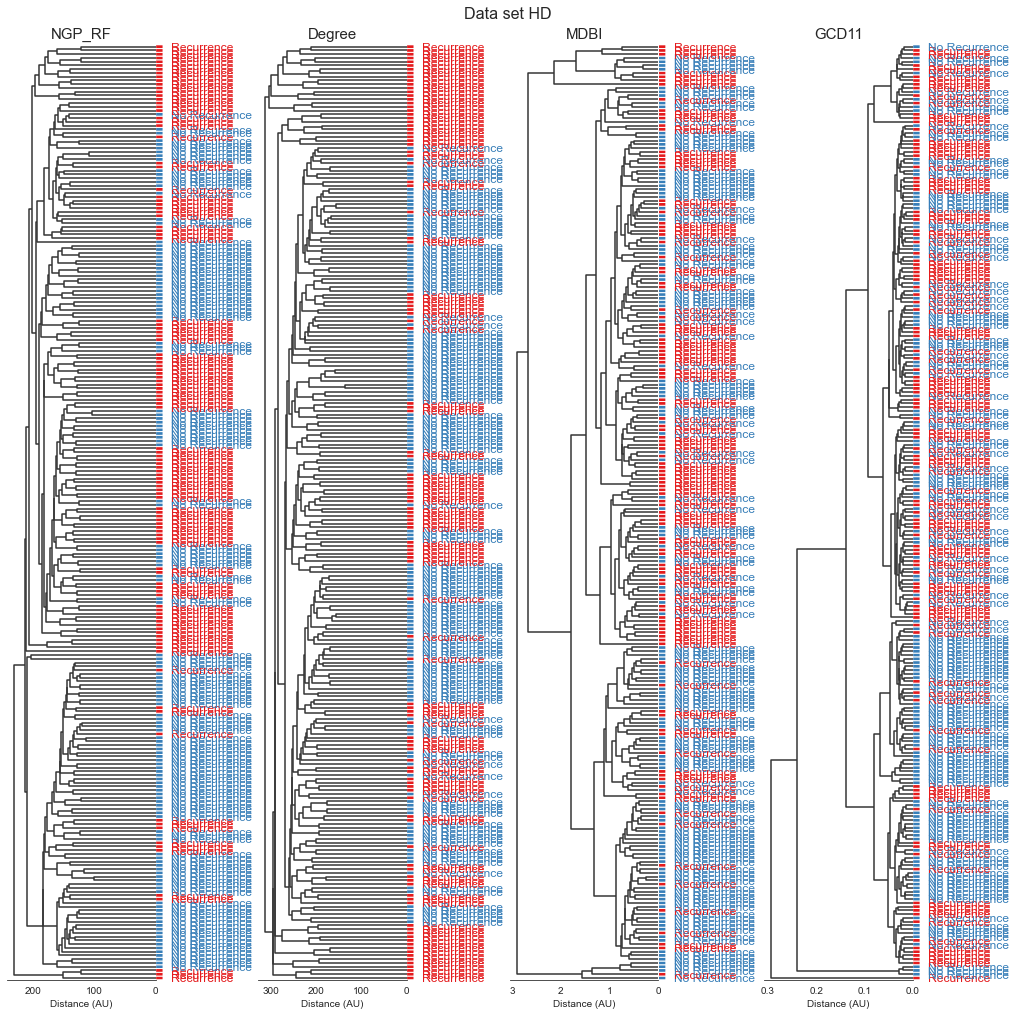

In [35]:
with sns.axes_style("white"):
    f, axs = plt.subplots(1, 4, figsize=(14, 14), constrained_layout=True)
    
    name = 'HD'
      
    for treatment, ax in zip(('NGP_RF', 'Degree', 'MDBI', 'GCD11'), axs.ravel()):
        plot_dendogram(HCA_all[name][treatment]['Z'], 
                       datasets[name]['target'], ax=ax,
                       label_colors=datasets[name]['label_colors'],
                       title=treatment, color_threshold=0)

    st = f.suptitle(f'Data set {datasets[name]["name"]}', fontsize=16)
    plt.show()

###  Dendrogram Similarity Comparison

The similarity of the dendrograms built from the differently-treated datasets of each of the benchmark datasets were compared using two correlation coefficients:

#### Cophenetic Correlation Coefficient

- Pearson Correlation of the matrix of cophenetic distances of two dendrograms.

#### Baker's Gamma Correlation Coefficient

- Use of the `mergerank` function from multianalysis.py to create a 'rank' of the iteration number two samples were linked to the same cluster. Then see Kendall Correlation between the results from 2 dendrograms according to Baker's paper or Spearman Correlation according to explanation given in the R package `dendextend`.

Baker's paper: Baker FB. Stability of Two Hierarchical Grouping Techniques Case 1: Sensitivity to Data Errors. J Am Stat Assoc. 1974;69(346):440-445. doi:10.2307/2285675

The information from HCA for these methods is already collected.

#### Examples of procedure with these methods with the Negative Grapevine Dataset - GDg2-

In [36]:
for name, ds in datasets.items():
    HCA_all[name] = {}
    print(f'Performing HCAs to {name} data set', end=' ...')
    for treat in 'P', 'NP', 'NGP', 'NGP_RF', 'IDT', 'Degree', 'Betweenness', 'Closeness', 'MDBI', 'GCD11':
        #print(f'Performing HCA to {name} data set with treatment {treat}', end=' ...')
        metric = 'euclidean'
        HCA_all[name][treat] = perform_HCA(datasets[name][treat], metric=metric, method='average')
    print('done!')

Performing HCAs to GD_neg_global2 data set ...done!
Performing HCAs to GD_pos_global2 data set ...done!
Performing HCAs to GD_neg_class2 data set ...done!
Performing HCAs to GD_pos_class2 data set ...done!
Performing HCAs to YD data set ...done!
Performing HCAs to vitis_types data set ...done!
Performing HCAs to HD data set ...done!


In [37]:
# Correation metrics
pearsonr = stats.pearsonr
kendalltau = stats.kendalltau
spearmanr = stats.spearmanr

table = []
t1 = HCA_all['GD_neg_global2']['P']
t2 = HCA_all['GD_neg_global2']['NP']
t3 = HCA_all['GD_neg_global2']['NGP']

r, p_value = pearsonr(t1['coph'][1], t2['coph'][1])
k, p_value_k = kendalltau(t1["Baker's Gamma"], t2["Baker's Gamma"])
s, p_value_s = spearmanr(t1["Baker's Gamma"], t2["Baker's Gamma"])
table.append({'Pair of samples': 'P Treat-NP Treat',
              'Cophenetic (Pearson)': r,
              '(coph) p-value': p_value,
              "Baker's (Kendall)":k,
              '(B-K) p-value': p_value_k,
              "Baker's (Spearman)":s,
              '(B-S) p-value': p_value_s,})

r, p_value = pearsonr(t1['coph'][1], t3['coph'][1])
k, p_value_k = kendalltau(t1["Baker's Gamma"], t3["Baker's Gamma"])
s, p_value_s = spearmanr(t1["Baker's Gamma"], t3["Baker's Gamma"])
table.append({'Pair of samples': 'P Treat-NGP Treat',
              'Cophenetic (Pearson)': r,
              '(coph) p-value': p_value,
              "Baker's (Kendall)":k,
              '(B-K) p-value': p_value_k,
              "Baker's (Spearman)":s,
              '(B-S) p-value': p_value_s,})

pd.DataFrame(table).set_index('Pair of samples')

,Cophenetic (Pearson),(coph) p-value,Baker's (Kendall),(B-K) p-value,Baker's (Spearman),(B-S) p-value
Pair of samples,,,,,,
P Treat-NP Treat,0.613094,8.075258e-56,0.443351,2.703801e-81,0.568517,1.921675e-91
P Treat-NGP Treat,0.590612,5.907507e-51,0.373487,2.812001e-54,0.461984,6.001312e-57


### Calculate all the pairwise correlations between the dendrograms

Choose the set of treatment/distance metric combination to consider to calculate the pairwise correlations. These are indicated by the strings in the treatments list. The colnames list has to follow the same logic as the treatments list.

In [38]:
# Column names and row names for the dataframes and heatmaps
# Collect results of HCAs

colnames = ['IDT', 'Degree', 'Betweenness', 'Closeness', 'MDBI', 'GCD-11']
treatments = ['IDT', 'Degree', 'Betweenness', 'Closeness', 'MDBI', 'GCD11']

colnames = ['NGP', 'NGP_RF', 'Degree', 'Betweenness', 'Closeness', 'MDBI', 'GCD-11']
treatments = ['NGP', 'NGP_RF', 'Degree', 'Betweenness', 'Closeness', 'MDBI', 'GCD11']

# Calculation of correlation coefficient by each method

def create_HCA_correlations(HCA_results, treatments, colnames):
    n_res = len(colnames)
    correlations = {key: np.empty((n_res, n_res)) for key in ('K', 'S', 'C', 'K_p', 'S_p', 'C_p')}

    for i, treat1 in enumerate(treatments):
        for j, treat2 in enumerate(treatments):
            Si, Sj = HCA_results[treat1], HCA_results[treat2]
            # K - Kendall (Baker's Gamma)
            k, p_value_k = stats.kendalltau(Si["Baker's Gamma"], Sj["Baker's Gamma"])
            correlations['K'][i,j], correlations['K_p'][i,j] = k, p_value_k

            # S - Spearman (Baker's Gamma)
            s, p_value_s = stats.spearmanr(Si["Baker's Gamma"], Sj["Baker's Gamma"])
            correlations['S'][i,j], correlations['S_p'][i,j] = s, p_value_s

            # C - Cophenetic Correlation
            r, p_value = stats.pearsonr(Si['coph'][1], Sj['coph'][1])
            correlations['C'][i,j], correlations['C_p'][i,j] = r, p_value

    for k in correlations:
        correlations[k] = pd.DataFrame(correlations[k], columns=colnames, index=colnames)
    return correlations

correlations_neg = create_HCA_correlations(HCA_all['GD_neg_global2'], treatments, colnames)
correlations_pos = create_HCA_correlations(HCA_all['GD_pos_global2'], treatments, colnames)

### Heatmaps of the correlation coeficients

As for the Baker's Gamma Correlation, the heatmaps presented will be the ones with corelation calculated with Kendall correlation (according to the original paper - Baker FB. Stability of Two Hierarchical Grouping Techniques Case 1: Sensitivity to Data Errors. J Am Stat Assoc. 1974;69(346):440-445. doi:10.2307/2285675).

Although, seeing the other correlations is just a case of changing the 'C's and 'K's to 'S's based on which set of correlations you want to see in the `combineCK` function (2 cells below).

Here, **two sets of heatmaps** - Baker's gamma (Kendall) correlation (upper) and cophenetic correlation (lower) - of the GDg2- or GDg2+ datasets with the IDT and the sample MDiN analysis metrics are shown.

Below are the functions to build these heatmaps.

In [39]:
def relative_luminance(color):
    """Calculate the relative luminance of a color according to W3C standards
    Parameters
    ----------
    color : matplotlib color or sequence of matplotlib colors
        Hex code, rgb-tuple, or html color name.
    Returns
    -------
    luminance : float(s) between 0 and 1
    """
    rgb = mpl.colors.to_rgba_array(color)[:, :3]
    rgb = np.where(rgb <= .03928, rgb / 12.92, ((rgb + .055) / 1.055) ** 2.4)
    lum = rgb.dot([.2126, .7152, .0722])
    try:
        return lum.item()
    except ValueError:
        return lum

def plot_partitioned_df_asheatmap(df, ax=None, cmap='viridis', vmin=None, vmax=None, norm=None,
                                  partition_point=0, top_rotate=False, fontsize=14, colorbar=True):
    
    if ax is None:
        ax = plt.gca()
    
    values = df.values.copy()
    #values = np.flipud(values)
    # handle partition point
    
    # insert NaN column/row in values
    values = np.insert(values, partition_point, np.nan, axis=1)
    #values = np.insert(values, df.shape[0]- partition_point, np.nan, axis=0)
    values = np.insert(values, partition_point, np.nan, axis=0)
    
    # compute and insert 2% offset
    X = np.array(range(values.shape[0] + 1), dtype=float)
    Y = np.array(range(values.shape[1] + 1), dtype=float)
    offset = X[-1] * 0.02
    
    X[(partition_point+1):] = np.arange(float(partition_point)+offset, float(len(X)-1), 1.0)
    Y[(partition_point+1):] = np.arange(float(partition_point)+offset, float(len(Y)-1), 1.0)
    #Y[(len(Y)-partition_point-1):] = np.arange(float(len(Y)-partition_point-2)+offset, float(len(Y)-1), 1.0)

    # draw pcolormesh
    pm = ax.pcolormesh(X, Y, values, cmap=cmap, vmin=vmin, vmax=vmax, norm=norm)
    ax.set_ylim(ax.get_ylim()[1], ax.get_ylim()[0])
    ax.set_aspect('equal')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
    # handle labels
    midpoints_x = (X[1:] - X[:-1]) / 2 + X[:-1]
    midpoints_x = np.delete(midpoints_x, partition_point)
    midpoints_y = (Y[1:] - Y[:-1]) / 2 + Y[:-1]
    midpoints_y = np.delete(midpoints_y, partition_point)
    ax.set_xticks(midpoints_x)
    ax.set_yticks(midpoints_y)
    ax.set_xticklabels(df.columns)
    ax.set_yticklabels(df.index)
    ax.tick_params(labeltop=True, labelbottom=False, labelsize=fontsize,
                   top=False, bottom=False, left=False, right=False)
    if top_rotate:
        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=90, ha="left", va='center', rotation_mode="anchor")
    
    # handle annotations
    
    pm_colors = pm.cmap(pm.norm(pm.get_array())).reshape(values.shape[0], values.shape[1], 4)
    mask = np.ones((values.shape[0], values.shape[1]), dtype=bool)
    mask[:, partition_point] = False
    mask[partition_point, :] = False
    pm_colors = pm_colors[mask].reshape(df.shape[0], df.shape[1], 4)
    #print(pm_colors)

    for i in range(df.shape[0]):
        for j in range(df.shape[1]):
            locx = midpoints_x[j]
            locy = midpoints_y[i]
            # handle label color according to cell color
            cell_color = pm_colors[i, j, :]
            lum = relative_luminance(cell_color)
            text_color = ".15" if lum > .408 else "w"
            annot = f'{df.iloc[i, j]:.2g}'
            text = ax.text(locx, locy, annot, fontsize=fontsize,
                           ha="center", va="center", color=text_color)

    if colorbar:
        plt.colorbar(pm)
    return pm

In [40]:
def combineCK(correlations):
    correlations['CK'] = correlations['C'].copy()
    # lower tringular mask
    upper_mask = np.triu(np.ones(correlations['CK'].shape)).astype(bool)
    correlations['CK'][upper_mask] = correlations['K']

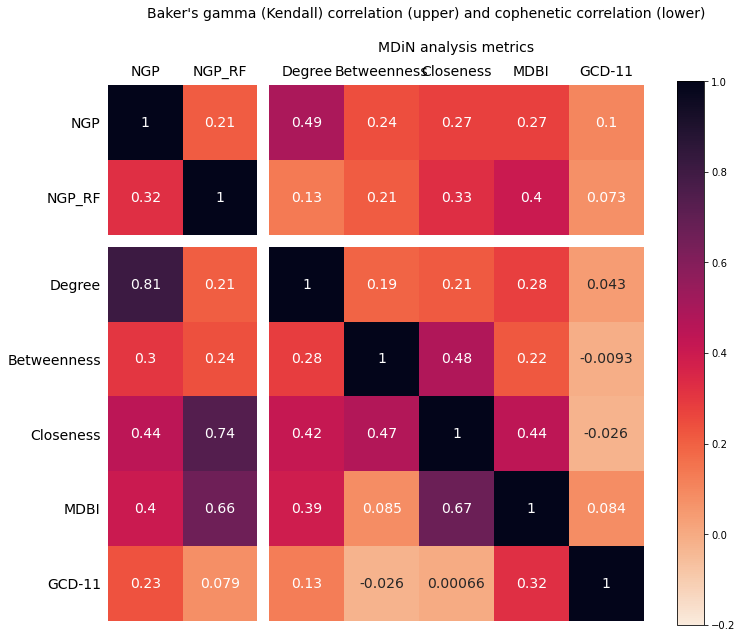

In [41]:
f, ax = plt.subplots(figsize=(12,10))

combineCK(correlations_neg)

pm = plot_partitioned_df_asheatmap(correlations_neg['CK'], ax=ax, vmin=-0.2, vmax=1,
                                    cmap=sns.color_palette("rocket_r", as_cmap=True),
                                    partition_point=2, top_rotate=False)
ax.text(4.25, -0.9, "Baker's gamma (Kendall) correlation (upper) and cophenetic correlation (lower)",
        ha='center', fontsize=14)

#f.suptitle("Data set GDg2-", fontsize=16, y=1.04)
#ax.text(1.5,-0.45, 'Traditional treatments', fontsize=14, ha='center')
ax.text(4.65,-0.45, 'MDiN analysis metrics', fontsize=14, ha='center')

plt.show()

#### Heatmaps combined in a single figure

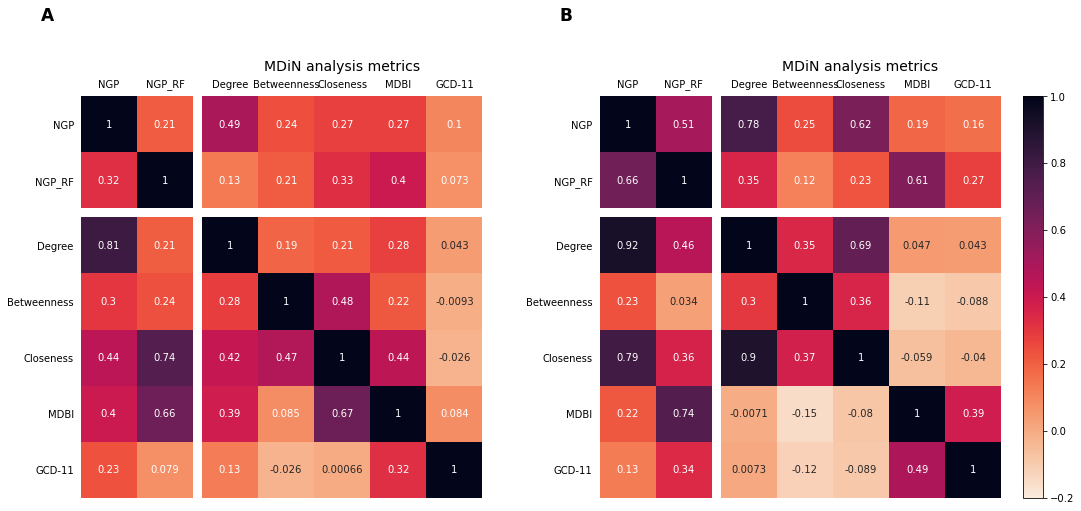

In [42]:
f, (axl, axr) = plt.subplots(1,2, figsize=(15,7), constrained_layout=True)

combineCK(correlations_neg)

pm = plot_partitioned_df_asheatmap(correlations_neg['CK'], ax=axl, vmin=-0.2, vmax=1,
                                    cmap=sns.color_palette("rocket_r", as_cmap=True), fontsize=10,
                                    partition_point=2, top_rotate=False, colorbar=False)

axl.text(4.65,-0.45, 'MDiN analysis metrics', fontsize=14, ha='center')

combineCK(correlations_pos)

pm = plot_partitioned_df_asheatmap(correlations_pos['CK'], ax=axr, vmin=-0.2, vmax=1,
                                    cmap=sns.color_palette("rocket_r", as_cmap=True), fontsize=10,
                                    partition_point=2, top_rotate=False)

axr.text(4.65,-0.45, 'MDiN analysis metrics', fontsize=14, ha='center')

for letter, ax in zip('ABCDEFGHIJ', (axl, axr)):
    ax.text(-0.1, 1.2, letter, ha='left', va='center', fontsize=17, weight='bold',
            transform=ax.transAxes,
            bbox=dict(facecolor='white', edgecolor='white', alpha=0.9))


#f.savefig('images/coph_baker_corrs.pdf', dpi=400)
#f.savefig('images/coph_baker_corrs.png', dpi=600)

plt.show()

## Evaluating Dendrogram (HCAs) Sample Discrimination

To evaluate the discrimination achieved with each HCA, 3 different metrics were used (explained in the paper):

- **Discrimination Distance** - the average of “class discrimination distance”. For each class, the discrimination distance is 0 if the class is not “correctly clustered” or it is the distance between the node that includes all the samples of the class and the next closest node (including those samples) in the agglomerative procedure, normalized by the maximum distance of any pair of nodes in the final resulting clustering.
- **Correct Clustering Percentage** - the percentage of the classes who are correctly clustered.
- **Correct First Cluster Percentage** - the percentage of samples whose first clustering was only with a sample(s) from its class.

Correct (Class) Clustering definition - samples of a class all clustered together before any other clustering with other samples or already-formed clusters in the agglomerative procedure.

Functions applied here (`dist_discrim` and `correct_1stcluster_fraction`) from multianalysis.py file of this repository with explanations of each step to calculate the different metrics.

In [43]:
def compute_clustering_metrics(res_dict, labels):
    """Fill dict with clustering performance metrics."""
    
    discrim = ma.dist_discrim(res_dict['Z'], labels, # all samples have the same order
                              method = 'average')
    res_dict['Average discrim dist'] = discrim[0]
    correct = np.array(list(discrim[1].values()))
    
    classes = pd.unique(labels)
    res_dict['% correct clustering'] = (100/len(classes)) * len(correct[correct>0])

    # Correct First Cluster Percentage
    res_dict['% correct 1st clustering'] = 100 * ma.correct_1stcluster_fraction(res_dict['Z'],labels)
    

### Dendrograms Discrimination Results

Compute clustering metrics for the dendrograms built deom the 6 benchmark datasets treated with an intensity-based pre-treatment or with the different analysis metrics used for the sample MDiNs.


See which of the intensity-based data pre-treatments (`NGP` or `NGP_RF`) leads to better HCA results based on the three discrimination metrics used for the work for each dataset to choose it as the `IDT`.

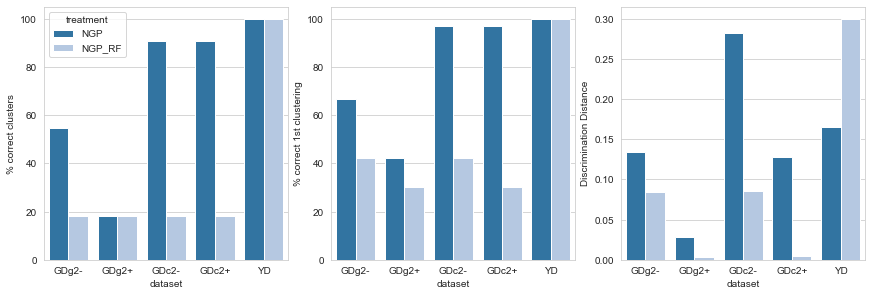

In [44]:
HCA_performance = []
for name, dataset in datasets.items():
    if name == 'vitis_types':
        continue
    elif name == 'HD':
        continue   
    
    for treatment in ('NGP', 'NGP_RF'):
        compute_clustering_metrics(HCA_all[name][treatment], datasets[name]['target'])
        perform = {'dataset': name, 'treatment': treatment,
                   'Discrimination Distance': HCA_all[name][treatment]['Average discrim dist'],
                   '% correct clusters': HCA_all[name][treatment]['% correct clustering'],
                   '% correct 1st clustering': HCA_all[name][treatment]['% correct 1st clustering']}
        HCA_performance.append(perform)
        
HCA_performance = pd.DataFrame(HCA_performance)

cv_dsnames = {name:datasets[name]['name'] for name in datasets}

HCA_performance2 = HCA_performance.assign(dataset = HCA_performance['dataset'].map(cv_dsnames))

p4 = sns.color_palette('tab20', 2)
with sns.axes_style("whitegrid"):
    f, axs = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)
    sns.barplot(x="dataset", y="Discrimination Distance", hue="treatment", data=HCA_performance2, ax=axs[2], palette=p4)
    sns.barplot(x="dataset", y="% correct clusters", hue="treatment", data=HCA_performance2, ax=axs[0], palette=p4)
    sns.barplot(x="dataset", y="% correct 1st clustering", hue="treatment", data=HCA_performance2, ax=axs[1], palette=p4)
    axs[1].legend().set_visible(False)
    axs[2].legend().set_visible(False)
    plt.show()

In [45]:
HCA_performance = []
for name, dataset in datasets.items():
    if name == 'vitis_types':
        continue
    elif name == 'HD':
        continue  
    
    for treatment in ('IDT', 'Degree', 'Betweenness', 'Closeness', 'MDBI', 'GCD11'):
        # Choice of the IDT for each dataset
        if treatment == 'IDT':
            if name == 'YD':
                compute_clustering_metrics(HCA_all[name]['NGP_RF'], datasets[name]['target'])
                perform = {'dataset': name, 'treatment': treatment,
                   'Discrimination Distance': HCA_all[name]['NGP_RF']['Average discrim dist'],
                   '% correct clusters': HCA_all[name]['NGP_RF']['% correct clustering'],
                   '% correct 1st clustering': HCA_all[name]['NGP_RF']['% correct 1st clustering']}
            else:
                compute_clustering_metrics(HCA_all[name]['NGP'], datasets[name]['target'])
                perform = {'dataset': name, 'treatment': treatment,
                   'Discrimination Distance': HCA_all[name]['NGP']['Average discrim dist'],
                   '% correct clusters': HCA_all[name]['NGP']['% correct clustering'],
                   '% correct 1st clustering': HCA_all[name]['NGP']['% correct 1st clustering']}
        # Data matrices of sMDiNs network analyses
        else:
            compute_clustering_metrics(HCA_all[name][treatment], datasets[name]['target'])
            perform = {'dataset': name, 'treatment': treatment,
                       'Discrimination Distance': HCA_all[name][treatment]['Average discrim dist'],
                       '% correct clusters': HCA_all[name][treatment]['% correct clustering'],
                       '% correct 1st clustering': HCA_all[name][treatment]['% correct 1st clustering']}
        HCA_performance.append(perform)
        
HCA_performance = pd.DataFrame(HCA_performance)

cv_dsnames = {name:datasets[name]['name'] for name in datasets}

HCA_performance2 = HCA_performance.assign(dataset = HCA_performance['dataset'].map(cv_dsnames))
HCA_performance2

,dataset,treatment,Discrimination Distance,% correct clusters,% correct 1st clustering
0,GDg2-,IDT,0.134477,54.545455,66.666667
1,GDg2-,Degree,0.126103,63.636364,75.757576
2,GDg2-,Betweenness,0.024301,9.090909,33.333333
3,GDg2-,Closeness,0.099204,54.545455,54.545455
4,GDg2-,MDBI,0.115873,18.181818,42.424242
5,GDg2-,GCD11,0.022842,9.090909,27.272727
6,GDg2+,IDT,0.028373,18.181818,42.424242
7,GDg2+,Degree,0.023551,18.181818,42.424242
8,GDg2+,Betweenness,0.000000,0.000000,18.181818
9,GDg2+,Closeness,0.014003,9.090909,33.333333


Results summary

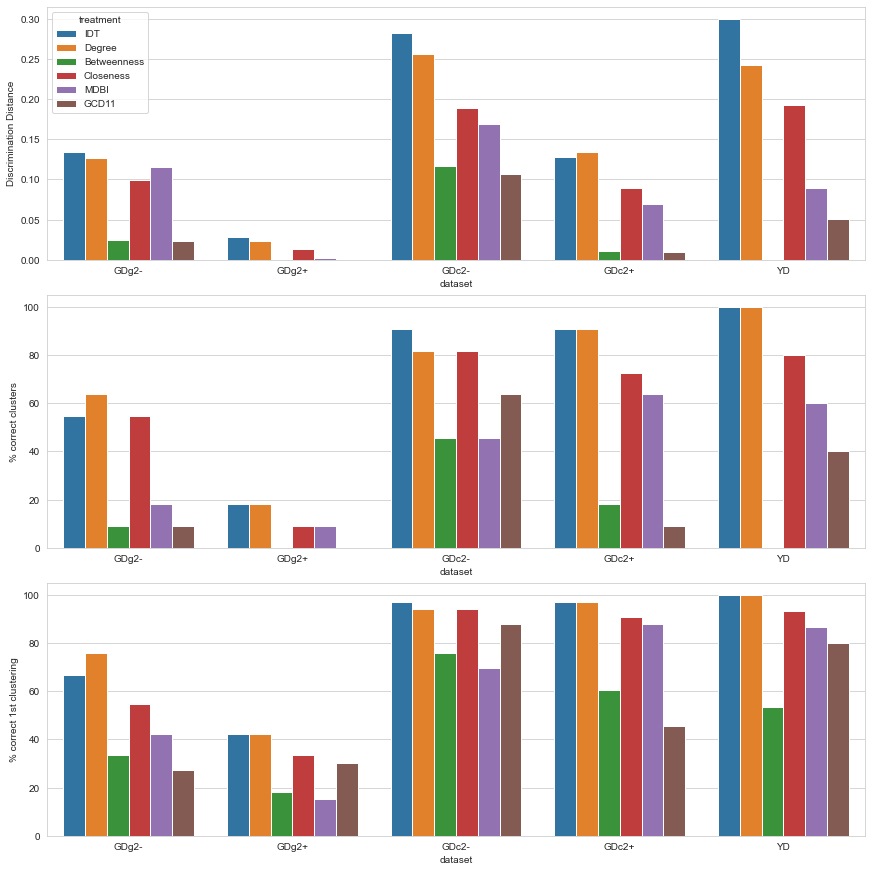

In [46]:
p4 = sns.color_palette('tab10', 6)
with sns.axes_style("whitegrid"):
    f, axs = plt.subplots(3, 1, figsize=(12, 12), constrained_layout=True)
    sns.barplot(x="dataset", y="Discrimination Distance", hue="treatment", data=HCA_performance2, ax=axs[0], palette=p4)
    sns.barplot(x="dataset", y="% correct clusters", hue="treatment", data=HCA_performance2, ax=axs[1], palette=p4)
    sns.barplot(x="dataset", y="% correct 1st clustering", hue="treatment", data=HCA_performance2, ax=axs[2], palette=p4)
    axs[1].legend().set_visible(False)
    axs[2].legend().set_visible(False)
    plt.show()

## K-means Clustering Analysis

K-means clustering analysis was applied by using the appropriate functions of the scikit-learn as done in the following cells.

#### K-means clustering was applied to all the datasets obtained for each of the 6 benchmark datasets

The number of clusters chosen was equal to the amount of groups. Apart from this, default parameters were used.

K-means clustering analysis has an intrinsically random side to it depending on the starting position of the clusters centroids and due to the existence of local minima. Due to this randomness, the algorithm was repeated 15 (n) times and the result with the least inertia (greater minimization of the objective function - sum of squared distances of the samples to the cluster centroids) was retained (best 10% of results, in this case, only the best).

To evaluate the discrimination achieved with each K-means Clustering, 3 different metrics were used (explained in the paper):

- **Discrimination Distance** (for K-means clustering, identical idea to HCA)
- **Correct Clustering Percentage** (for K-means clustering, identical idea to HCA)
- **Adjusted Rand Index** (calculated by scikit-learn - `adjusted_rand_index`) - proportion of sample pairs which are correctly clustered or correctly not clustered, adjusted for the expected percentage of samples which would be in those situations randomly.

The function `Kmeans_discrim` from multianalysis.py was applied to calculate these metrics with explanations of each step to calculate the different metrics.

Correct clustering definition - K-means Cluster contains all and only the samples of a single class (stricter definition than in HCA). Samples of a class can all be together in a cluster, but if another sample (of another class) is present, the class is not correctly clustered. Thus, the Correct Clustering Percentage is expected to be lower in this case.

In this case, the distances are calculated by the distance between different cluster centroids.

In [47]:
import sklearn.cluster as skclust
from sklearn.metrics import adjusted_rand_score

In [48]:
def perform_KMeans(dataset, treatment, iter_num=150, best_fraction=0.1):
    "Perform K-means Clustering Analysis and calculate discrimination evaluation metrics."
    
    sample_labels = datasets[dataset]['target']
    n_classes = len(pd.unique(sample_labels))
    
    df = datasets[dataset][treatment]
    
    discrim = ma.Kmeans_discrim(df, sample_labels,
                                method='average', 
                                iter_num=iter_num,
                                best_fraction=best_fraction)

    
    # Lists for the results of the best k-means clustering
    average = []
    correct = []
    rand = []
    
    for j in discrim:
        global_disc_dist, disc_dists, rand_index, SSE = discrim[j]
        
        # Average of discrimination distances
        average.append(global_disc_dist) 
        
        # Correct Clustering Percentages
        all_correct = np.array(list(disc_dists.values()))
        correct.append(len(all_correct[all_correct>0]))
        
        # Adjusted Rand Index
        rand.append(rand_index) 
    
    return{'dataset': dataset,
           'treatment': treatment,
           'Discrimination Distance': np.median(average),
           '% correct clusters':np.median(correct)*100/n_classes,
           'Rand Index': np.median(rand)}

See which of the intensity-based data pre-treatments (`NGP` or `NGP_RF`) leads to better K-means clustering results based on the three discrimination metrics used for the work for each dataset to choose it as the `IDT`.

performing KMeans on GD_neg_global2 with treatment NGP ...done!
performing KMeans on GD_neg_global2 with treatment NGP_RF ...done!
performing KMeans on GD_pos_global2 with treatment NGP ...done!
performing KMeans on GD_pos_global2 with treatment NGP_RF ...done!
performing KMeans on GD_neg_class2 with treatment NGP ...done!
performing KMeans on GD_neg_class2 with treatment NGP_RF ...done!
performing KMeans on GD_pos_class2 with treatment NGP ...done!
performing KMeans on GD_pos_class2 with treatment NGP_RF ...done!
performing KMeans on YD with treatment NGP ...done!
performing KMeans on YD with treatment NGP_RF ...done!


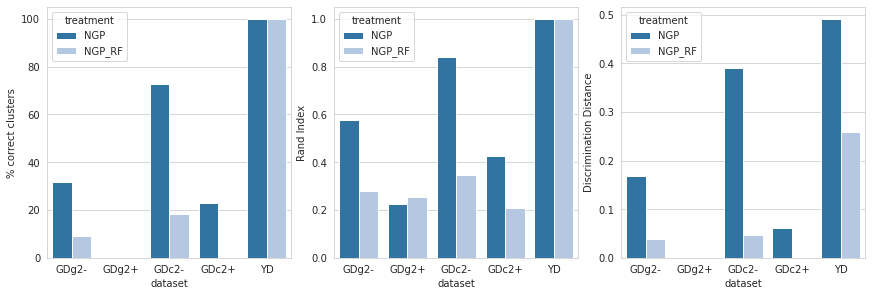

In [49]:
iter_num=15

KMeans_all = []

for dsname in ('GD_neg_global2', 'GD_pos_global2', 'GD_neg_class2', 'GD_pos_class2', 'YD'):
    for treatment in ('NGP', 'NGP_RF'):
        print(f'performing KMeans on {dsname} with treatment {treatment}' , end=' ...')
        KMeans_all.append(perform_KMeans(dsname, treatment, iter_num=iter_num))
        print('done!')
        
KMeans_all = pd.DataFrame(KMeans_all)

cv_dsnames = {name:datasets[name]['name'] for name in datasets}
KMeans_all2 = KMeans_all.assign(dataset = KMeans_all['dataset'].map(cv_dsnames))

KMeans_all2

p4 = sns.color_palette('tab20', 2)
with sns.axes_style("whitegrid"):
    f, axs = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)
    sns.barplot(x="dataset", y="Discrimination Distance", hue="treatment", data=KMeans_all2, ax=axs[2], palette=p4)
    sns.barplot(x="dataset", y="% correct clusters", hue="treatment", data=KMeans_all2, ax=axs[0], palette=p4)
    sns.barplot(x="dataset", y="Rand Index", hue="treatment", data=KMeans_all2, ax=axs[1], palette=p4)

K-means Clustering Analysis

In [50]:
# NOTE: for debugging
iter_num=15
# otherwise
#iter_num=150

KMeans_all = []

for dsname in ('GD_neg_global2', 'GD_pos_global2', 'GD_neg_class2', 'GD_pos_class2', 'YD'):
    # Choice of the IDT for each dataset
    datasets[dsname]['IDT'] = datasets[dsname]['NGP']
    for treatment in ('IDT', 'Degree', 'Betweenness', 'Closeness', 'MDBI', 'GCD11'):
        print(f'performing KMeans on {dsname} with treatment {treatment}' , end=' ...')
        KMeans_all.append(perform_KMeans(dsname, treatment, iter_num=iter_num))
        print('done!')

performing KMeans on GD_neg_global2 with treatment IDT ...done!
performing KMeans on GD_neg_global2 with treatment Degree ...done!
performing KMeans on GD_neg_global2 with treatment Betweenness ...done!
performing KMeans on GD_neg_global2 with treatment Closeness ...done!
performing KMeans on GD_neg_global2 with treatment MDBI ...done!
performing KMeans on GD_neg_global2 with treatment GCD11 ...done!
performing KMeans on GD_pos_global2 with treatment IDT ...done!
performing KMeans on GD_pos_global2 with treatment Degree ...done!
performing KMeans on GD_pos_global2 with treatment Betweenness ...done!
performing KMeans on GD_pos_global2 with treatment Closeness ...done!
performing KMeans on GD_pos_global2 with treatment MDBI ...done!
performing KMeans on GD_pos_global2 with treatment GCD11 ...done!
performing KMeans on GD_neg_class2 with treatment IDT ...done!
performing KMeans on GD_neg_class2 with treatment Degree ...done!
performing KMeans on GD_neg_class2 with treatment Betweenness .

In [51]:
KMeans_all = pd.DataFrame(KMeans_all)

cv_dsnames = {name:datasets[name]['name'] for name in datasets}
KMeans_all2 = KMeans_all.assign(dataset = KMeans_all['dataset'].map(cv_dsnames))

In [52]:
KMeans_all2

,dataset,treatment,Discrimination Distance,% correct clusters,Rand Index
0,GDg2-,IDT,0.144516,27.272727,0.571654
1,GDg2-,Degree,0.219554,45.454545,0.498146
2,GDg2-,Betweenness,0.000000,0.000000,0.229404
3,GDg2-,Closeness,0.155909,36.363636,0.468842
4,GDg2-,MDBI,0.083108,18.181818,0.268725
5,GDg2-,GCD11,0.026266,9.090909,0.218861
6,GDg2+,IDT,0.018250,4.545455,0.246878
7,GDg2+,Degree,0.000000,0.000000,0.232000
8,GDg2+,Betweenness,0.007461,9.090909,0.143169
9,GDg2+,Closeness,0.046209,9.090909,0.236257


Results summary

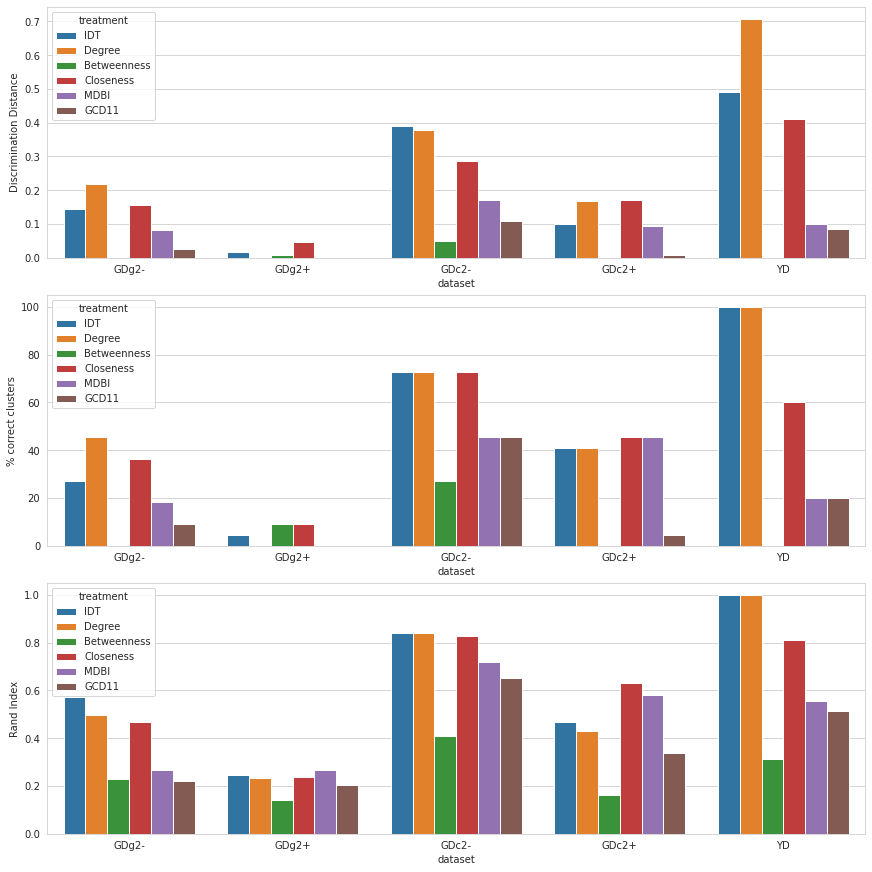

In [53]:
p4 = sns.color_palette('tab10', 6)
with sns.axes_style("whitegrid"):
    f, axs = plt.subplots(3, 1, figsize=(12, 12), constrained_layout=True)
    #for ax in axs.ravel():
        #ax.tick_params(labelsize=14)
        #ax.xaxis.label.set_size(16)
        #ax.axhspan(-0.5, 3.5, color='red', alpha=0.2)
        #ax.axhspan(3.55, 7.5, color='darkblue', alpha=0.2)
        #ax.axhspan(7.55, 11.5, color='red', alpha=0.2)
        #ax.axhspan(11.55, 16, color='darkblue', alpha=0.2)
    sns.barplot(x="dataset", y="Discrimination Distance", hue="treatment", data=KMeans_all2, ax=axs[0], palette=p4)
    sns.barplot(x="dataset", y="% correct clusters", hue="treatment", data=KMeans_all2, ax=axs[1], palette=p4)
    sns.barplot(x="dataset", y="Rand Index", hue="treatment", data=KMeans_all2, ax=axs[2], palette=p4)

## Summary of Clustering performance

HCA and K-means Clustering results combined.

In [54]:
def endminus(x):
    if x.endswith('-'):
        return x.replace('-', '−')
    else:
        return x

HCA_performance2['dataset'] = HCA_performance2['dataset'].apply(endminus)
KMeans_all2['dataset'] = KMeans_all2['dataset'].apply(endminus)

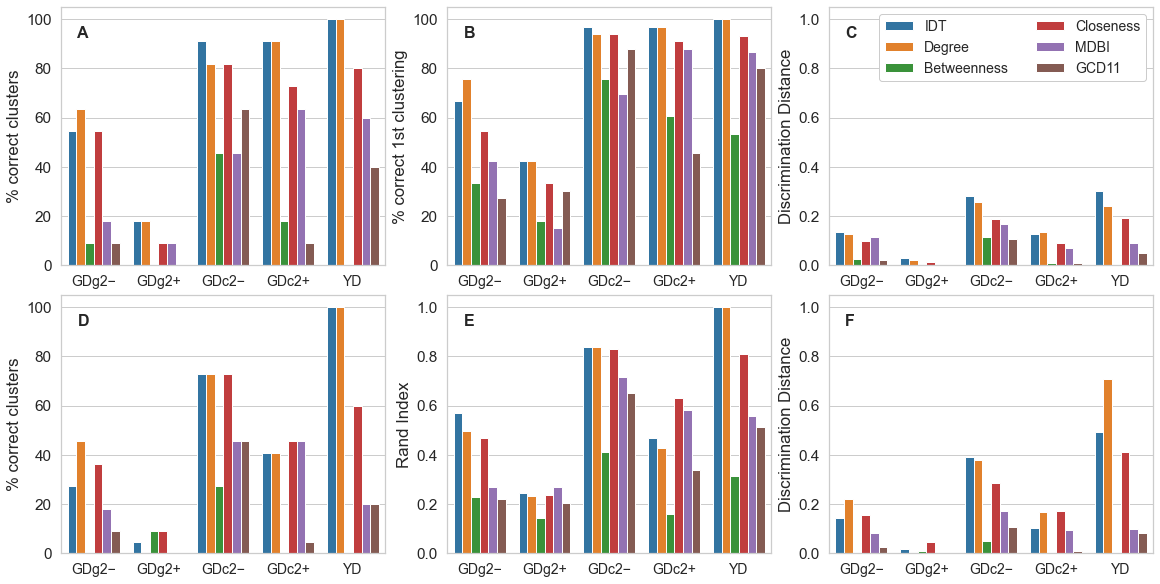

In [55]:
p4 = sns.color_palette('tab10', 6)
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.4):
        f, axs = plt.subplots(2, 3, figsize=(16, 8), constrained_layout=True)
        sns.barplot(x="dataset", y="Discrimination Distance", hue="treatment", data=HCA_performance2, ax=axs[0][2], palette=p4)
        sns.barplot(x="dataset", y="% correct clusters", hue="treatment", data=HCA_performance2, ax=axs[0][0], palette=p4)
        sns.barplot(x="dataset", y="% correct 1st clustering", hue="treatment", data=HCA_performance2, ax=axs[0][1], palette=p4)

        sns.barplot(x="dataset", y="Discrimination Distance", hue="treatment", data=KMeans_all2, ax=axs[1][2], palette=p4)
        sns.barplot(x="dataset", y="% correct clusters", hue="treatment", data=KMeans_all2, ax=axs[1][0], palette=p4)
        sns.barplot(x="dataset", y="Rand Index", hue="treatment", data=KMeans_all2, ax=axs[1][1], palette=p4)
        for i, ax in enumerate(axs.ravel()):
            ax.set_ylim(0,105)
            ax.xaxis.label.set_visible(False)
            ax.legend().set_visible(False)
            ax.tick_params(axis='x', which='major', labelsize=14)
        #axs[0][1].set_title('HCA', fontsize=15)
        #axs[1][1].set_title('KMeans', fontsize=15)
        axs[0][2].legend(bbox_to_anchor=(1,1), loc="upper right", framealpha=1, fontsize=14, ncol=2)
        axs[1][2].set_ylim(0,1.05)
        axs[1][1].set_ylim(0,1.05)
        axs[0][2].set_ylim(0,1.05)
        
        for letter, ax in zip('ABCDEFGHIJ', axs.ravel()):
            ax.text(0.05, 0.9, letter, ha='left', va='center', fontsize=16, weight='bold',
                    transform=ax.transAxes,
                    bbox=dict(facecolor='white', edgecolor='white', alpha=0.9))

        plt.show()

        f.savefig('images/clust_performance.pdf' , dpi=600)
        f.savefig('images/clust_performance.png' , dpi=600)
        #f.savefig('images/clust_performance.svg')